In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
# from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [62]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89()-[]{};:'"“\’<>./@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [63]:
df=pd.read_excel('/content/drive/MyDrive/text_classification/123.xlsx')
display(df)

,content,category
0,আপনার সাথে আমার একটি গোপন পরার্মশ আছে ।,incorrect
1,আপনার সঙ্গে আমার একটি গোপনীয় পরার্মশ আছে ।,correct
2,তোমার সাথে আমার একটি গোপন পরার্মশ আছে ।,incorrect
3,তোমার সঙ্গে আমার একটি গোপনীয় পরামর্শ আছে ।,correct
4,মনে রাখবে আবশ্যকীয় ব্যয়ে কার্পণ্যতা অনুচিৎ ।,incorrect
...,...,...
4399,মূমুর্ষু অবস্থায় স্যার হাসপাতালে রয়েছেন ।,incorrect
4400,মূমুর্ষু অবস্থায় রহিম সাহেব হাসপাতালে রয়েছেন ।,incorrect
4401,তার দুর্নীবার ইচ্ছা শক্তি বাধা অতিক্রম করবে ।,incorrect
4402,ব্যাকরন বইটি নিয়ে আসো।,incorrect


In [64]:
pip install bnlp-toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from bnlp import POS

text = 'রাখাল গরুর পাল লয়ে মাঠে যায় ।'

bn_pos = POS()
model_path = "/content/drive/MyDrive/text_classification/bn_pos.pkl"
sd = bn_pos.tag(model_path,text)
print(sd)


[('রাখাল', 'NP'), ('গরুর', 'NP'), ('পাল', 'NP'), ('লয়ে', 'NC'), ('মাঠে', 'VM'), ('যায়', 'VAUX'), ('।', 'PU')]


In [66]:
from bnlp import POS
bn_pos = POS()
model_path = "/content/drive/MyDrive/text_classification/bn_pos.pkl"
pos_data = []
for i in df['content']:
      r= bn_pos.tag(model_path,i)
      pos_data.append(r)

In [67]:
mod_data = []
for i in range(len(pos_data)):
  data = ' '
  for j in range(len(pos_data[i])):
    for text in pos_data[i][j]:
      data = data + text + " "
  mod_data.append({
      'content': data.strip()
  })
mod_data = pd.DataFrame(mod_data)
mod_data

,content
0,আপনার PPR সাথে PP আমার PPR একটি JQ গোপন NC পরা...
1,আপনার PPR সঙ্গে PP আমার PPR একটি JQ গোপনীয় JJ ...
2,তোমার PPR সাথে PP আমার PPR একটি JQ গোপন NC পরা...
3,তোমার PPR সঙ্গে PP আমার PPR একটি JQ গোপনীয় JJ ...
4,মনে NC রাখবে VM আবশ্যকীয় JJ ব্যয়ে NC কার্পণ্যত...
...,...
4399,মূমুর্ষু NC অবস্থায় NC স্যার NC হাসপাতালে NC র...
4400,মূমুর্ষু NC অবস্থায় NC রহিম NP সাহেব NP হাসপাত...
4401,তার PPR দুর্নীবার JQ ইচ্ছা NC শক্তি NC বাধা NC...
4402,ব্যাকরন NC বইটি NC নিয়ে VM আসো VAUX । PU


In [68]:
df['content'] = mod_data['content'] 

In [69]:
df.category[df['category']=='correct']= 0
df.category[df['category']=='incorrect']=1

In [70]:
df

,content,category
0,আপনার PPR সাথে PP আমার PPR একটি JQ গোপন NC পরা...,1
1,আপনার PPR সঙ্গে PP আমার PPR একটি JQ গোপনীয় JJ ...,0
2,তোমার PPR সাথে PP আমার PPR একটি JQ গোপন NC পরা...,1
3,তোমার PPR সঙ্গে PP আমার PPR একটি JQ গোপনীয় JJ ...,0
4,মনে NC রাখবে VM আবশ্যকীয় JJ ব্যয়ে NC কার্পণ্যত...,1
...,...,...
4399,মূমুর্ষু NC অবস্থায় NC স্যার NC হাসপাতালে NC র...,1
4400,মূমুর্ষু NC অবস্থায় NC রহিম NP সাহেব NP হাসপাত...,1
4401,তার PPR দুর্নীবার JQ ইচ্ছা NC শক্তি NC বাধা NC...,1
4402,ব্যাকরন NC বইটি NC নিয়ে VM আসো VAUX । PU,1


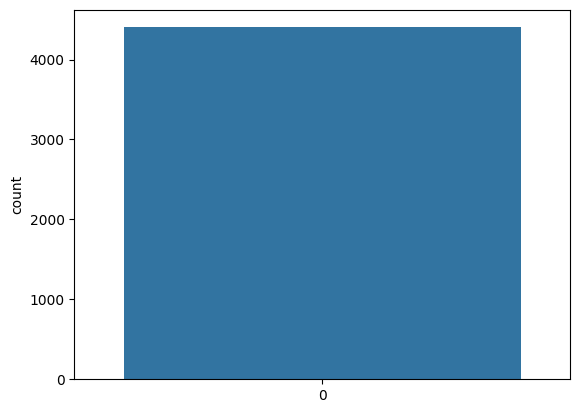

In [71]:
sns.countplot(df['category']);

In [72]:
pip install bnlp-toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
df.reset_index(drop=True, inplace=True)

In [74]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_sentences = []
testing_sentences = []



train_sentences=train1['content'].values
train_labels=train1['category'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['content'].values
test_labels=test1['category'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 3523
Testing Set Length: 881
training_sentences shape: (3523,)
testing_sentences shape: (881,)
train_labels shape: (3523, 2)
test_labels shape: (881, 2)


In [75]:
print(training_sentences[1])
print(train_labels[0])

সূর্য JJ উদয় NC হয়েছে VM । PU
[0. 1.]


In [76]:
vocab_size = 2500
embedding_dim = 100
max_length = 20
trunc_type='post'
oov_tok = "<OOV>"

In [77]:
print(training_sentences.shape)
print(train_labels.shape)

(3523,)
(3523, 2)


In [78]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

2137
Word index length:2137


In [79]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

মহারাজ NC সভাকক্ষে NC প্রবেশ NC করলেন VM । PU

Sentence Tokenized and Converted into Sequence :--> 

[1601, 2, 890, 2, 159, 2, 891, 4, 5, 3]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0 1601    2  890    2
  159    2  891    4    5    3]


In [80]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (3523, 20)
Padded shape(testing): (881, 20)


# **LSTM**

In [81]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
import numpy as np

# Define the LSTM model architecture
l_model = Sequential()
l_model.add(Embedding(input_dim=len(word_index)+1, output_dim=100, input_length=max_length))
l_model.add(LSTM(units=64))
l_model.add(Dense(units=2, activation='sigmoid'))
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
l_model.summary()
l_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 100)           213800    
                                                                 
 lstm_7 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
Total params: 256,170
Trainable params: 256,170
Non-trainable params: 0
_________________________________________________________________


In [82]:
history0= l_model.fit(padded,train_labels, validation_data=(testing_padded,test_labels), epochs=15, batch_size=64)

Epoch 1/15
56/56 [==============================] - 6s 48ms/step - loss: 0.6912 - accuracy: 0.5246 - val_loss: 0.6807 - val_accuracy: 0.5902
Epoch 2/15
56/56 [==============================] - 2s 35ms/step - loss: 0.5786 - accuracy: 0.7187 - val_loss: 0.5824 - val_accuracy: 0.6992
Epoch 3/15
56/56 [==============================] - 2s 36ms/step - loss: 0.2901 - accuracy: 0.8961 - val_loss: 0.3081 - val_accuracy: 0.8876
Epoch 4/15
56/56 [==============================] - 4s 81ms/step - loss: 0.1458 - accuracy: 0.9466 - val_loss: 0.2323 - val_accuracy: 0.9262
Epoch 5/15
56/56 [==============================] - 4s 79ms/step - loss: 0.1188 - accuracy: 0.9560 - val_loss: 0.2131 - val_accuracy: 0.9262
Epoch 6/15
56/56 [==============================] - 4s 73ms/step - loss: 0.0799 - accuracy: 0.9733 - val_loss: 0.1744 - val_accuracy: 0.9489
Epoch 7/15
56/56 [==============================] - 5s 81ms/step - loss: 0.0710 - accuracy: 0.9750 - val_loss: 0.2021 - val_accuracy: 0.9432
Epoch 8/15
56

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


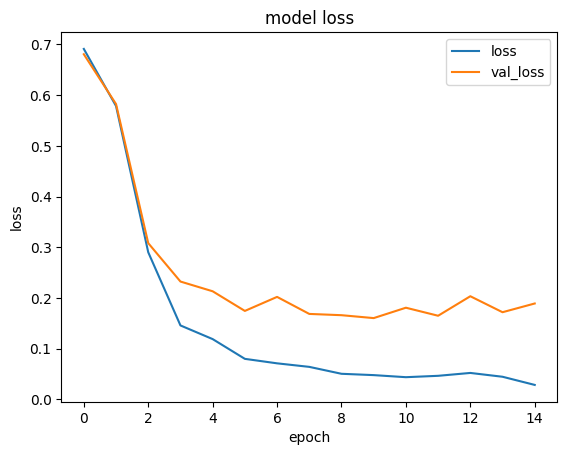

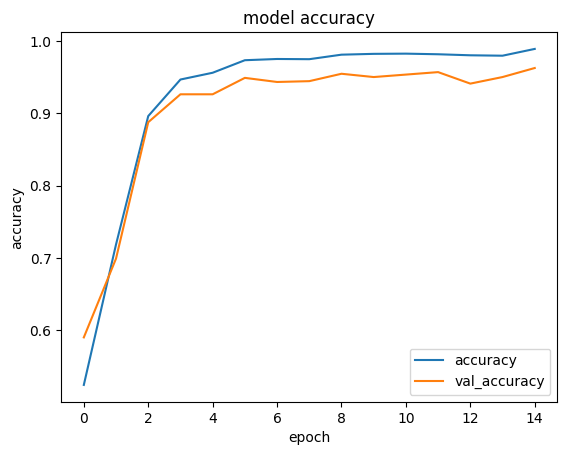

In [83]:
print(history0.history.keys())
loss = history0.history['loss']
val_loss = history0.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history0.history['accuracy']
val_accuracy= history0.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [84]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you already have a trained LSTM model and test data
y_pred = l_model.predict(testing_padded)
y_pred = np.round(y_pred)

# Convert predictions and true labels to binary (0/1)
y_pred = y_pred.astype(int)
y_true = np.array(test_labels)

# Generate the classification report
report = classification_report(y_true, y_pred, digits=4)

# Print the report
print(report)

28/28 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0     0.9566    0.9714    0.9639       454
           1     0.9667    0.9532    0.9599       427

   micro avg     0.9615    0.9625    0.9620       881
   macro avg     0.9617    0.9623    0.9619       881
weighted avg     0.9615    0.9625    0.9620       881
 samples avg     0.9620    0.9625    0.9622       881



In [85]:
#accuracy calculation
loss_and_metrics = l_model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = l_model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

14/14 [==============================] - 0s 26ms/step - loss: 0.0250 - accuracy: 0.9906
The train accuracy is: 0.9906330108642578
4/4 [==============================] - 0s 22ms/step - loss: 0.1891 - accuracy: 0.9625
The test accuracy is: 0.9625425934791565


28/28 [==============================] - 0s 7ms/step


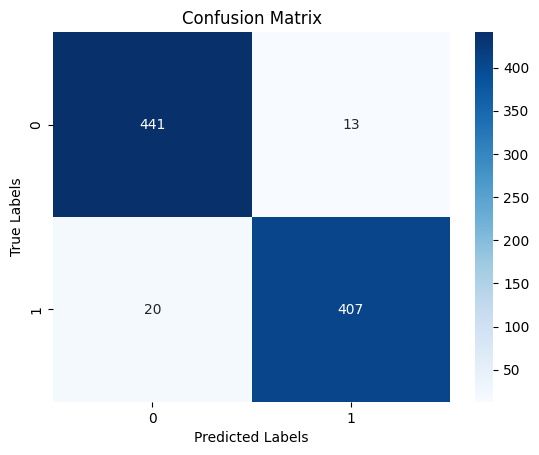

In [86]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Get predicted labels from your deep learning model
y_pred = l_model.predict(testing_padded)
# print(y_pred)
# y_pred = np.round(y_pred)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred)
# Get true labels for the test set
y_true = test_labels
y_true = np.argmax(y_true, axis=1)
# print(y_true)

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Generate heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# **CNN**

In [125]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Define the CNN model architecture
c_model = Sequential()
c_model.add(Embedding(input_dim=len(word_index)+1, output_dim=100, input_length=max_length))
c_model.add(Conv1D(filters=12, kernel_size=5, padding='same', activation='relu'))
c_model.add(GlobalMaxPooling1D())
c_model.add(Dense(units=2, activation='sigmoid'))
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
c_model.summary()
# Compile the model
c_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 20, 100)           213800    
                                                                 
 conv1d_8 (Conv1D)           (None, 20, 12)            6012      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 12)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 2)                 26        
                                                                 
Total params: 219,838
Trainable params: 219,838
Non-trainable params: 0
_________________________________________________________________


In [126]:
history1 = c_model.fit(padded,train_labels, validation_data=(testing_padded,test_labels), epochs=10, batch_size=64)

Epoch 1/10
56/56 [==============================] - 2s 16ms/step - loss: 0.6908 - accuracy: 0.5544 - val_loss: 0.6845 - val_accuracy: 0.5914
Epoch 2/10
56/56 [==============================] - 1s 13ms/step - loss: 0.6659 - accuracy: 0.7252 - val_loss: 0.6538 - val_accuracy: 0.7719
Epoch 3/10
56/56 [==============================] - 1s 14ms/step - loss: 0.5955 - accuracy: 0.8629 - val_loss: 0.5595 - val_accuracy: 0.8150
Epoch 4/10
56/56 [==============================] - 1s 14ms/step - loss: 0.4200 - accuracy: 0.9191 - val_loss: 0.3809 - val_accuracy: 0.8661
Epoch 5/10
56/56 [==============================] - 1s 14ms/step - loss: 0.2213 - accuracy: 0.9486 - val_loss: 0.2395 - val_accuracy: 0.9160
Epoch 6/10
56/56 [==============================] - 1s 13ms/step - loss: 0.1192 - accuracy: 0.9674 - val_loss: 0.1764 - val_accuracy: 0.9274
Epoch 7/10
56/56 [==============================] - 1s 19ms/step - loss: 0.0779 - accuracy: 0.9773 - val_loss: 0.1477 - val_accuracy: 0.9342
Epoch 8/10
56

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


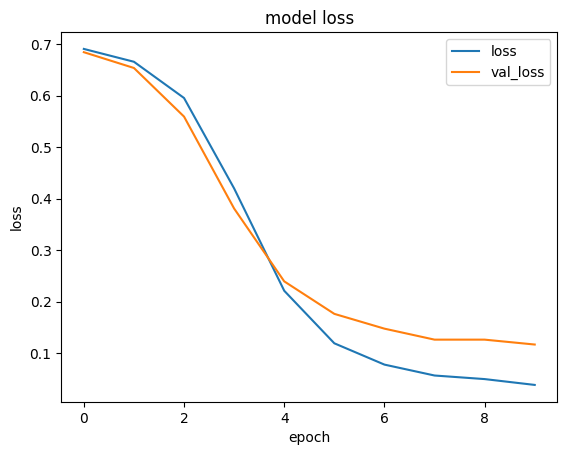

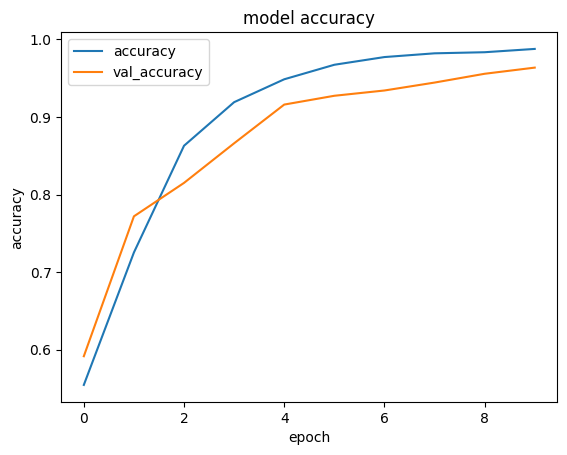

In [128]:
print(history1.history.keys())
loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history1.history['accuracy']
val_accuracy= history1.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [129]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you already have a trained LSTM model and test data
y_pred = c_model.predict(testing_padded)
y_pred = np.round(y_pred)

# Convert predictions and true labels to binary (0/1)
y_pred = y_pred.astype(int)
y_true = np.array(test_labels)

# Generate the classification report
report = classification_report(y_true, y_pred, digits=4)

# Print the report
print(report)

28/28 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9648    0.9648    0.9648       454
           1     0.9560    0.9672    0.9616       427

   micro avg     0.9605    0.9659    0.9632       881
   macro avg     0.9604    0.9660    0.9632       881
weighted avg     0.9605    0.9659    0.9632       881
 samples avg     0.9620    0.9659    0.9633       881



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
#accuracy calculation
loss_and_metrics = c_model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = c_model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

14/14 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9943
The train accuracy is: 0.9943230152130127
4/4 [==============================] - 0s 8ms/step - loss: 0.1168 - accuracy: 0.9637
The test accuracy is: 0.9636776447296143


In [131]:
y_pred = c_model.predict(testing_padded)
y_true = test_labels

28/28 [==============================] - 0s 2ms/step


In [132]:
y_pred

array([[0.00309901, 0.9961203 ],
       [0.9988071 , 0.00242161],
       [0.99509895, 0.00643575],
       ...,
       [0.03593029, 0.9610334 ],
       [0.01854124, 0.9740367 ],
       [0.9075011 , 0.1740564 ]], dtype=float32)

In [95]:
import pandas as pd
df = pd.DataFrame(y_pred)
# print(df)
df.to_excel('y_pred.xlsx', index=False, header=False)

In [96]:
df = pd.DataFrame(y_true)
# print(df)
df.to_excel('y_true.xlsx', index=False, header=False)

28/28 [==============================] - 0s 2ms/step


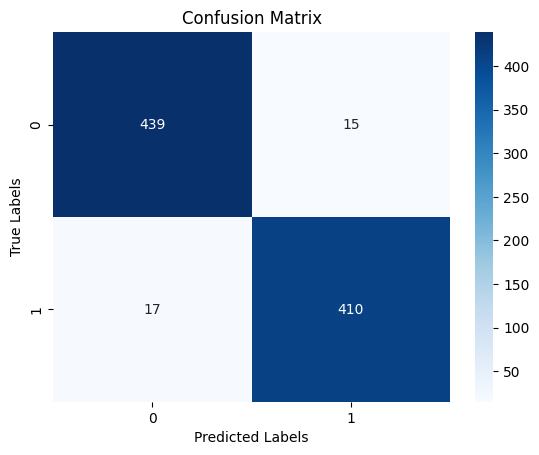

In [133]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Get predicted labels from your deep learning model
y_pred = c_model.predict(testing_padded)
# print(y_pred)
# y_pred = np.round(y_pred)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred)
# Get true labels for the test set
y_true = test_labels
y_true = np.argmax(y_true, axis=1)
# print(y_true)

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Generate heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# **CNN-LSTM**

In [134]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(100, kernel_size=3, activation = "relu"))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(50,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 100)           250000    
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 100)           30100     
                                                                 
 bidirectional_10 (Bidirecti  (None, 18, 64)           34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 18, 64)            0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 25)              

In [135]:
history=model.fit(padded,train_labels,epochs=15,batch_size=64,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=4)

Epoch 1/15
56/56 [==============================] - 16s 104ms/step - loss: 0.9455 - accuracy: 0.5158 - val_loss: 0.8717 - val_accuracy: 0.4847
Epoch 2/15
56/56 [==============================] - 6s 103ms/step - loss: 0.7776 - accuracy: 0.6228 - val_loss: 0.7093 - val_accuracy: 0.6640
Epoch 3/15
56/56 [==============================] - 4s 69ms/step - loss: 0.4263 - accuracy: 0.8618 - val_loss: 0.4038 - val_accuracy: 0.8649
Epoch 4/15
56/56 [==============================] - 4s 68ms/step - loss: 0.1921 - accuracy: 0.9481 - val_loss: 0.2479 - val_accuracy: 0.9251
Epoch 5/15
56/56 [==============================] - 6s 103ms/step - loss: 0.1019 - accuracy: 0.9756 - val_loss: 0.2054 - val_accuracy: 0.9432
Epoch 6/15
56/56 [==============================] - 4s 69ms/step - loss: 0.0716 - accuracy: 0.9804 - val_loss: 0.2018 - val_accuracy: 0.9523
Epoch 7/15
56/56 [==============================] - 4s 68ms/step - loss: 0.0533 - accuracy: 0.9844 - val_loss: 0.1914 - val_accuracy: 0.9569
Epoch 8/1

# Visualization

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


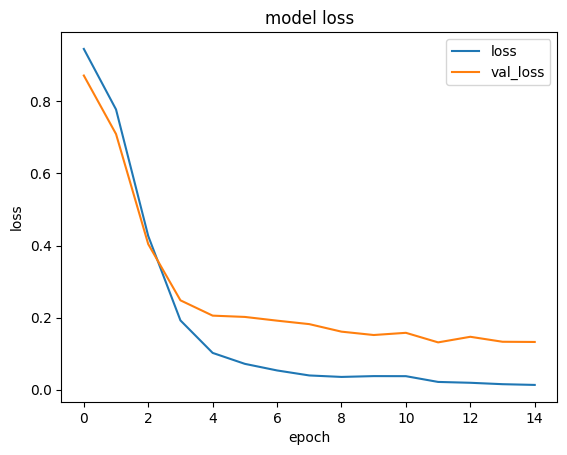

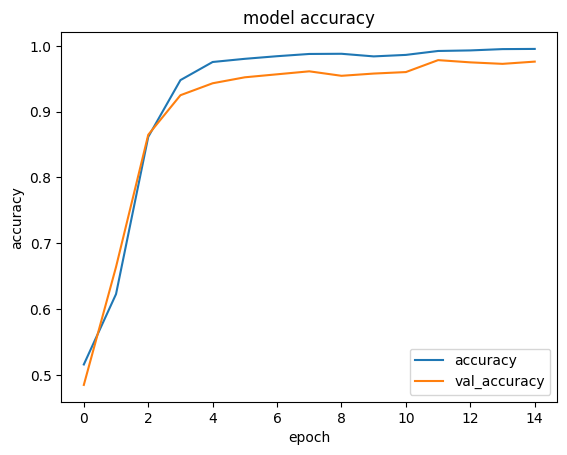

In [136]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [137]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you already have a trained LSTM model and test data
y_pred = model.predict(testing_padded)
y_pred = np.round(y_pred)

# Convert predictions and true labels to binary (0/1)
y_pred = y_pred.astype(int)
y_true = np.array(test_labels)

# Generate the classification report
report = classification_report(y_true, y_pred, digits=4)

# Print the report
print(report)

28/28 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0     0.9887    0.9648    0.9766       454
           1     0.9635    0.9883    0.9757       427

   micro avg     0.9762    0.9762    0.9762       881
   macro avg     0.9761    0.9765    0.9762       881
weighted avg     0.9765    0.9762    0.9762       881
 samples avg     0.9762    0.9762    0.9762       881



# Accuracy and Evaluation

In [138]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

14/14 [==============================] - 1s 46ms/step - loss: 0.0114 - accuracy: 0.9952
The train accuracy is: 0.9951745867729187
4/4 [==============================] - 0s 41ms/step - loss: 0.1323 - accuracy: 0.9762
The test accuracy is: 0.9761634469032288


28/28 [==============================] - 0s 12ms/step


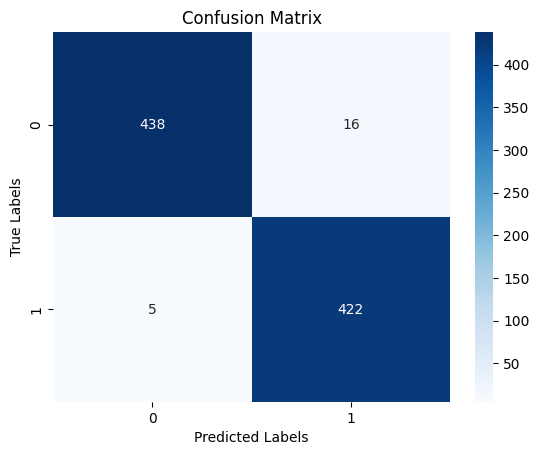

In [139]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Get predicted labels from your deep learning model
y_pred = model.predict(testing_padded)
# print(y_pred)
# y_pred = np.round(y_pred)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred)
# Get true labels for the test set
y_true = test_labels
y_true = np.argmax(y_true, axis=1)
# print(y_true)

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Generate heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# **BiLSTM**

In [140]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense



# Define the model architecture
model_bi = Sequential()
model_bi.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_bi.add(Bidirectional(LSTM(128)))
model_bi.add(Dense(2, activation='sigmoid'))
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model_bi.summary()

# Compile the model
model_bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 100)           250000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 2)                 514       
                                                                 
Total params: 485,010
Trainable params: 485,010
Non-trainable params: 0
_________________________________________________________________


In [141]:
# Train the model
history_bi=model_bi.fit(padded,train_labels,epochs=15,batch_size=64,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=4)

Epoch 1/15
56/56 [==============================] - 13s 150ms/step - loss: 0.6921 - accuracy: 0.5163 - val_loss: 0.6894 - val_accuracy: 0.4960
Epoch 2/15
56/56 [==============================] - 7s 115ms/step - loss: 0.5829 - accuracy: 0.6889 - val_loss: 0.5646 - val_accuracy: 0.7514
Epoch 3/15
56/56 [==============================] - 7s 128ms/step - loss: 0.2666 - accuracy: 0.9015 - val_loss: 0.2983 - val_accuracy: 0.9012
Epoch 4/15
56/56 [==============================] - 7s 127ms/step - loss: 0.1438 - accuracy: 0.9526 - val_loss: 0.2273 - val_accuracy: 0.9228
Epoch 5/15
56/56 [==============================] - 7s 121ms/step - loss: 0.0980 - accuracy: 0.9648 - val_loss: 0.1802 - val_accuracy: 0.9319
Epoch 6/15
56/56 [==============================] - 7s 131ms/step - loss: 0.0721 - accuracy: 0.9742 - val_loss: 0.1893 - val_accuracy: 0.9387
Epoch 7/15
56/56 [==============================] - 6s 105ms/step - loss: 0.0582 - accuracy: 0.9725 - val_loss: 0.1764 - val_accuracy: 0.9478
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


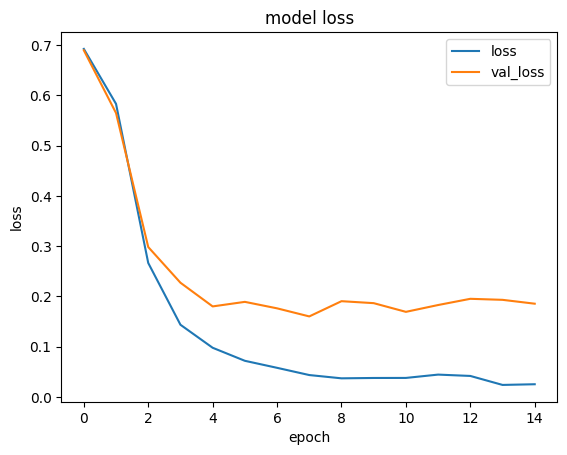

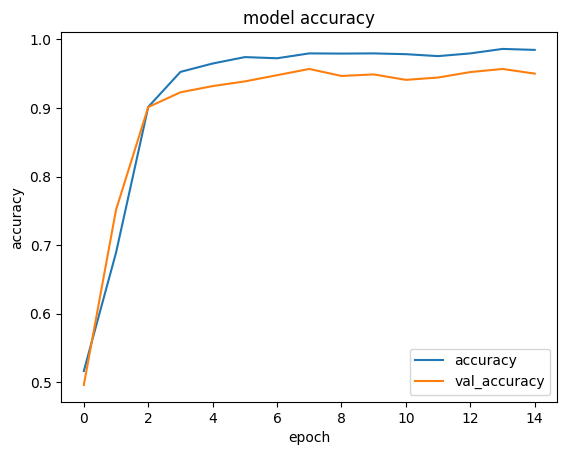

In [142]:
print(history_bi.history.keys())
loss = history_bi.history['loss']
val_loss = history_bi.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history_bi.history['accuracy']
val_accuracy= history_bi.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [143]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you already have a trained LSTM model and test data
y_pred = model_bi.predict(testing_padded)
y_pred = np.round(y_pred)

# Convert predictions and true labels to binary (0/1)
y_pred = y_pred.astype(int)
y_true = np.array(test_labels)

# Generate the classification report
report = classification_report(y_true, y_pred, digits=4)

# Print the report
print(report)

28/28 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0     0.9418    0.9626    0.9521       454
           1     0.9592    0.9368    0.9479       427

   micro avg     0.9501    0.9501    0.9501       881
   macro avg     0.9505    0.9497    0.9500       881
weighted avg     0.9503    0.9501    0.9500       881
 samples avg     0.9501    0.9501    0.9501       881



In [144]:
#accuracy calculation
loss_and_metrics = model_bi.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model_bi.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

14/14 [==============================] - 1s 84ms/step - loss: 0.0217 - accuracy: 0.9886
The train accuracy is: 0.9886460304260254
4/4 [==============================] - 0s 73ms/step - loss: 0.1856 - accuracy: 0.9501
The test accuracy is: 0.9500567317008972


28/28 [==============================] - 1s 21ms/step


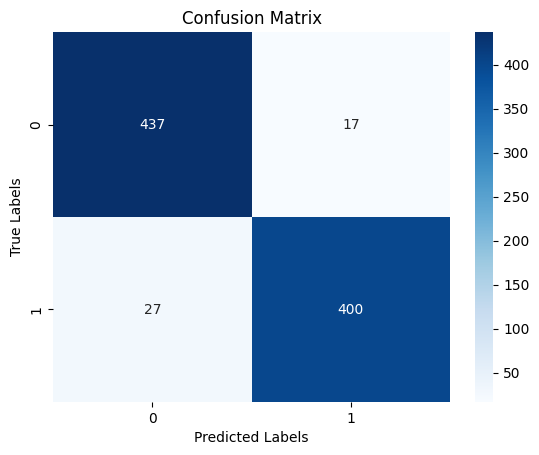

In [145]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Get predicted labels from your deep learning model
y_pred = model_bi.predict(testing_padded)
# print(y_pred)
# y_pred = np.round(y_pred)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred)
# Get true labels for the test set
y_true = test_labels
y_true = np.argmax(y_true, axis=1)
# print(y_true)

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Generate heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# **CNN-BiLSTM**

In [158]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from keras.models import Model

# Define the input layer
inputs = Input(shape=(max_length,), dtype='int32')

# Add the embedding layer
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_length)(inputs)

# Add the first convolutional layer
conv1_layer = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(embedding_layer)
pool1_layer = MaxPooling1D(pool_size=2)(conv1_layer)

# Add the second convolutional layer
conv2_layer = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(pool1_layer)
pool2_layer = MaxPooling1D(pool_size=2)(conv2_layer)

# Add the first BiLSTM layer
bilstm1_layer = Bidirectional(LSTM(units=64, return_sequences=True))(pool2_layer)

# Add the second BiLSTM layer
bilstm2_layer = Bidirectional(LSTM(units=32))(bilstm1_layer)


# Add a dense layer with dropout
dense1_layer = Dense(units=128, activation='relu')(bilstm2_layer)
dropout_layer = Dropout(rate=0.33)(dense1_layer)

# Add a second dense output layer
output_layer = Dense(units=2, activation='softmax')(dropout_layer)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

model.summary()


adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20)]              0         
                                                                 
 embedding_21 (Embedding)    (None, 20, 100)           250000    
                                                                 
 conv1d_22 (Conv1D)          (None, 20, 64)            12864     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 10, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 10, 32)            4128      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 5, 32)            0         
 g1D)                                                      

In [159]:
# Train the model
history_cb=model.fit(padded,train_labels,epochs=10,batch_size=64,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=4)

Epoch 1/10
56/56 [==============================] - 14s 72ms/step - loss: 0.6928 - accuracy: 0.5149 - val_loss: 0.6929 - val_accuracy: 0.4847
Epoch 2/10
56/56 [==============================] - 2s 36ms/step - loss: 0.6068 - accuracy: 0.6565 - val_loss: 0.5141 - val_accuracy: 0.7696
Epoch 3/10
56/56 [==============================] - 2s 35ms/step - loss: 0.2140 - accuracy: 0.9214 - val_loss: 0.2087 - val_accuracy: 0.9308
Epoch 4/10
56/56 [==============================] - 2s 42ms/step - loss: 0.0735 - accuracy: 0.9736 - val_loss: 0.1246 - val_accuracy: 0.9614
Epoch 5/10
56/56 [==============================] - 3s 61ms/step - loss: 0.0420 - accuracy: 0.9855 - val_loss: 0.1131 - val_accuracy: 0.9762
Epoch 6/10
56/56 [==============================] - 2s 39ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 0.1180 - val_accuracy: 0.9762
Epoch 7/10
56/56 [==============================] - 2s 36ms/step - loss: 0.0168 - accuracy: 0.9940 - val_loss: 0.1276 - val_accuracy: 0.9796
Epoch 8/10
5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


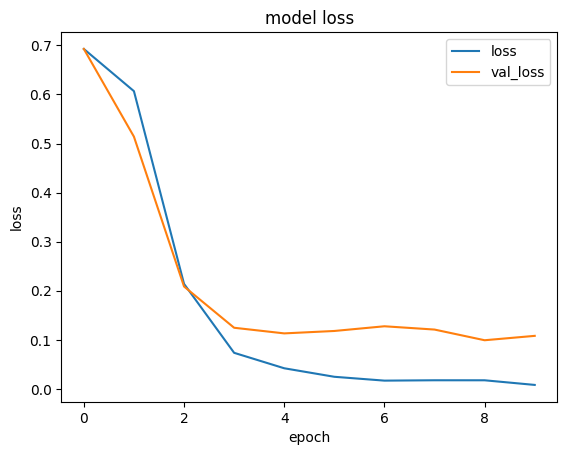

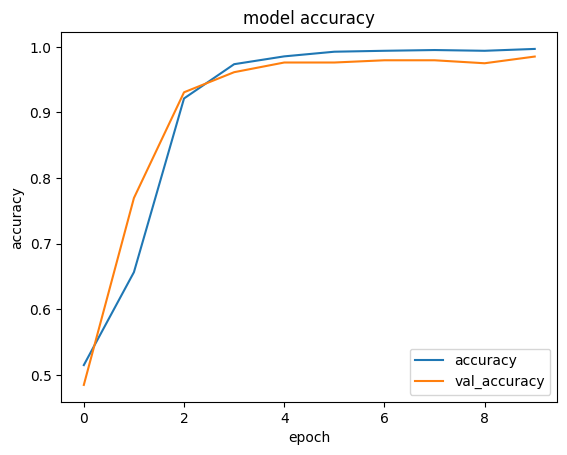

In [160]:
print(history_cb.history.keys())
loss = history_cb.history['loss']
val_loss = history_cb.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history_cb.history['accuracy']
val_accuracy= history_cb.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [161]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you already have a trained LSTM model and test data
y_pred = model.predict(testing_padded)
y_pred = np.round(y_pred)

# Convert predictions and true labels to binary (0/1)
y_pred = y_pred.astype(int)
y_true = np.array(test_labels)

# Generate the classification report
report = classification_report(y_true, y_pred, digits=4)

# Print the report
print(report)

28/28 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

           0     0.9846    0.9868    0.9857       454
           1     0.9859    0.9836    0.9848       427

   micro avg     0.9852    0.9852    0.9852       881
   macro avg     0.9853    0.9852    0.9852       881
weighted avg     0.9852    0.9852    0.9852       881
 samples avg     0.9852    0.9852    0.9852       881



28/28 [==============================] - 0s 7ms/step


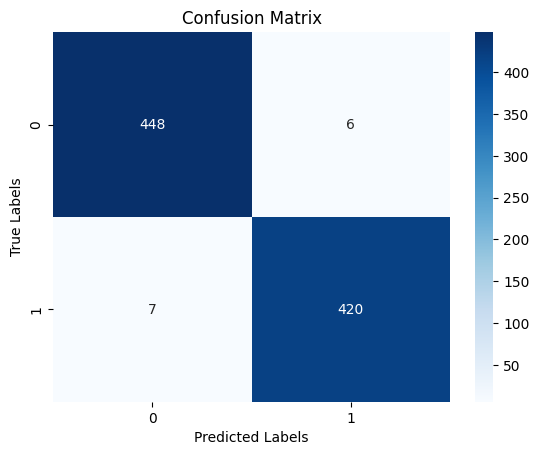

In [162]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Get predicted labels from your deep learning model
y_pred = model.predict(testing_padded)
# print(y_pred)
# y_pred = np.round(y_pred)
y_pred = np.argmax(y_pred, axis=1)
# print(y_pred)
# Get true labels for the test set
y_true = test_labels
y_true = np.argmax(y_true, axis=1)
# print(y_true)

# Generate a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Generate heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

28/28 [==============================] - 0s 7ms/step


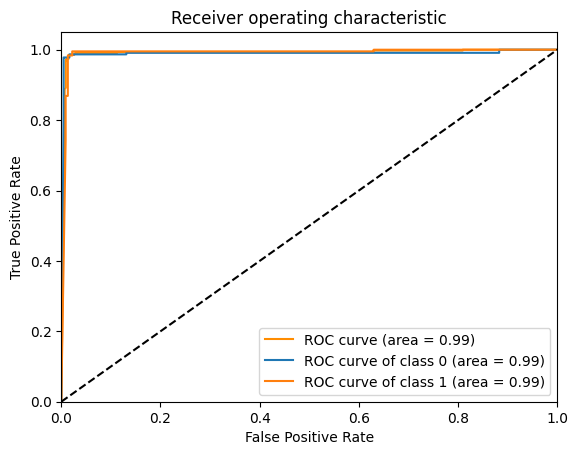

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
num_classes=2
# obtain predicted probabilities and true labels for test set
y_pred = model.predict(testing_padded)
y_true = test_labels

# compute ROC curve and AUC for each label
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', label='ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [116]:
import pickle
! pip install bnlp-toolkit
! pip install bltk
from bltk.langtools import Tokenizer
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached bltk-1.2.tar.gz (17.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for bltk: filename=bltk-1.2-py3-none-any.whl size=17432537 sha256=2fb81b1adc4579d08b435f0fd4a96105e427179849fe184cd21437b7022f3227
  Stored in directory: /root/.cache/pip/wheels/40/95/27/80bfbeb60364f00de71ea3570cb9b76ab17c8e8ab944c2d81b
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=e4b92c46887bf5d1e0851c372ae89fa6b7c5eaaccd25e94fb260bb85df7dfce6
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built bltk sklearn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [117]:
text ="আমি ভাত খাই । আমার নাম আনিক ।"

In [118]:
def process_sentence(lines):
  mod = []
  for line in lines:
    r= bn_pos.tag(model_path,line)
    data = ' '
    for i in range(len(r)):
      for j in range(len(r[i])):
          data = data + r[i][j] + " "
    data = data.strip()
    mod.append(data)
  return mod
# process_sentence(lines)

In [119]:
# For single data

# data = ' '
# for i in range(len(converted_text)):
#   for j in range(len(converted_text[i])):
#       data = data + converted_text[i][j] + " "
# data = data.strip()
# data

In [120]:
# Xi_token = tokenizer.texts_to_sequences([data])
# Xi_pad = pad_sequences(Xi_token, padding='post', maxlen=max_length)
# print('Model predicts')
# preds = model.predict(Xi_pad)
# preds

In [121]:
tok = Tokenizer()

In [122]:
def generate_response():
    input_sentence = input('Enter input message: ')
    input_sentence = tok.sentence_tokenizer(input_sentence)
    input_sentence= process_sentence(input_sentence)
    print(input_sentence)
    for sentence in input_sentence:
      print('Sentence : '+sentence)
      Xi_token = tokenizer.texts_to_sequences([sentence])
      Xi_pad = pad_sequences(Xi_token, padding='post', maxlen=max_length)
      preds = model.predict(Xi_pad)
      print('Confidence :')
      preds = preds
      total = 0
      for k in range(len(preds[0])):
          W= np.argmax(keras.utils.to_categorical([[k]]))
          if W == 0:
            print('Correct :',end=" ")
          else:
            print('Incorrect :',end=" ")
          print(str (round(preds[0,k]*100))+'%')
          total += preds[0,k]*100

In [123]:
generate_response()

KeyboardInterrupt: ignored